Go to working repository

In [2]:
%cd ../binfo1-work

/rna/seojin/proj/bioinformatics/bioinfo_term_proj/binfo1-work


Make LIN28A(antibody 35L33G) CLIP PileUp from BAM.
In order to control the + and - strand, make the reverse PileUp using FLAG 16(option -f 16 in samtools view)

In [2]:
!samtools mpileup ../binfo1-datapack1/CLIP-35L33G.bam > Seojin_Termproj/CLIP-35L33G.pileup
!wc -l CLIP-35L33G.pileup
!samtools view -f 16 ../CLIP-35L33G.bam -o reverse_CLIP-35L33G.bam
!samtools mpileup reverse_CLIP-35L33G.bam > reverse_CLIP-35L33G.pileup
!wc -l reverse_CLIP-35L33G.pileup

[mpileup] 1 samples in 1 input files
68548 CLIP-let7g.pileup


695484251 reverse_CLIP-35L33G.pileup

In [3]:
!head Seojin_Termproj/CLIP-35L33G.pileup

chr1	3056473	N	4	^!G^!G^!G^!G	HGGI
chr1	3056474	N	4	AAAA	HB@I
chr1	3056475	N	4	AAAA	GG?I
chr1	3056476	N	4	TTTT	HGGH
chr1	3056477	N	4	GGGG	HEGI
chr1	3056478	N	4	GGGG	GEEI
chr1	3056479	N	4	AAAA	EA=I
chr1	3056480	N	4	AAAA	@AEH
chr1	3056481	N	4	GGGG	GFFI
chr1	3056482	N	4	TTTT	G=BG


In [ ]:
!head Seojin_Termproj/reverse_CLIP-35L33G.pileup

chr1    3059006 N       8       ^!t^!t^!t^!t^!t^!t^!t^!t        EIGDDD?I
chr1    3059007 N       8       tttttttt        GFDDF?3I
chr1    3059008 N       8       cccccccc        7GDGI>BI
chr1    3059009 N       8       aaaaaaaa        :IBGH>BI
chr1    3059010 N       8       tttttttt        7DGGH>BI
chr1    3059011 N       8       tttttttt        7DGBI?;I
chr1    3059012 N       8       tttttttt        6IBGI>;I
chr1    3059013 N       8       aaaaaaaa        DHGGI??I
chr1    3059014 N       8       cccccccc        GIGEGBFI
chr1    3059015 N       8       aaaaaaaa        GHGGG@DH

In [3]:
import pandas as pd

(Fig2A) CRES >= 0.8 (Shannon Entrophy) and read counts >= 50 to get highly mutated coordinates

In [16]:
pileup = pd.read_csv('Seojin_Termproj/CLIP-35L33G.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
# pileup.tail()

KeyboardInterrupt: 

Leave only match(. or ,), mismatch(ACGT or acgt), deletion(* or */#) from basereads. I won't consider insertion(+)

In [17]:
import re


- Use substitution and deletion to calculate Shannon entropy. Before that, check for pattern other than -(number)NN...N

In [6]:
# (+or-)(any number k)(length k with word with at leaste 1 element in ATGCatgc) to regex
pattern = re.compile(r'[\+\-]([1-9][0-9]*)((?=.*[ATGCatgc])[A-Za-z]{\1})')

for row in pileup.itertuples():
    # check if pattern is contained in the basereads
    match = pattern.search(row.basereads)
    if match:
        print(match.groups())

- There is no -3ATG case. All of the deletion is marked as -3NNN format. Therefore, select only substitution and deletion(marked *) for Shannon Entrophy calculation. 

In [7]:
toremove = re.compile('[^ATGCatgc\*]') 
pileup['filtered_basereads'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_2155664/3979841347.py:1: SyntaxWarning: invalid escape sequence '\*'
  toremove = re.compile('[^ATGCatgc\*]')


In [8]:
import numpy as np
def Shannon_entropy(match):
    num_A = match.upper().count('A')
    num_T = match.upper().count('T')
    num_G = match.upper().count('G')
    num_C = match.upper().count('C')
    num_del = match.upper().count('*')

    # Calculate total number of valid bases
    total_bases = num_A + num_T + num_G + num_C + num_del

    # Calculate probabilities
    if total_bases > 0:
        p_A = num_A / total_bases
        p_T = num_T / total_bases
        p_G = num_G / total_bases
        p_C = num_C / total_bases
        p_del = num_del / total_bases

        # Calculate Shannon entropy
        entropy = 0
        for p in [p_A, p_T, p_G, p_C, p_del]:
            if p > 0:
                entropy -= p * np.log2(p)
    else:
        entropy = 0

    return entropy


In [13]:
def Calculate_Shannon_Entropy(pileup):
    for row in pileup.itertuples():
        shannon_entropy = Shannon_entropy(row.filtered_basereads)
        pileup.at[row.Index, 'Shannon_entropy'] = shannon_entropy

In [14]:
Calculate_Shannon_Entropy(pileup)

In [15]:
pileup.head()

,chrom,pos,_ref,count,basereads,quals,filtered_basereads,Shannon_entropy
0,chr1,3056473,N,4,^!G^!G^!G^!G,HGGI,GGGG,0.0
1,chr1,3056474,N,4,AAAA,HB@I,AAAA,0.0
2,chr1,3056475,N,4,AAAA,GG?I,AAAA,0.0
3,chr1,3056476,N,4,TTTT,HGGH,TTTT,0.0
4,chr1,3056477,N,4,GGGG,HEGI,GGGG,0.0


If the corresponding location is in - strand, I will make the sequence to reverse complementary

In [ ]:
!wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/GRCm39.primary_assembly.genome.fa.gz
!gunzip GRCm39.primary_assembly.genome.fa.gz
!samtools faidx GRCm39.primary_assembly.genome.fa

- Select CRES >= 0.8 and read counts >= 50 which is highly mutated location

In [20]:
mutation_rich = pileup[(pileup['Shannon_entropy'] > 0.8) & (pileup['count'] > 50)]

In [24]:
len(mutation_rich)
mutation_rich.head()
mutation_rich.to_csv('Seojin_Termproj/CLIP-35L33G_with_Shannon_mutation_rich.pileup', sep='\t', index=False)

In [4]:
mutation_rich = pd.read_csv('Seojin_Termproj/CLIP-35L33G_with_Shannon_mutation_rich.pileup', sep='\t')

- Map reverse complement need locations to selected mutation rich pileup file. This will mark - strands for selected highly mutation rich coordinates.

In [5]:
reverse_pileup = pd.read_csv('Seojin_Termproj/reverse_CLIP-35L33G.pileup', sep='\t', names=['chrom', 'pos'])

In [25]:
# Ensure reverse_pileup has necessary columns for merging
reverse_pileup_subset = reverse_pileup[['pos', 'chrom']].copy()
reverse_pileup_subset['reverse_comp'] = 1

# Merge mutation_rich with reverse_pileup to find matching positions and chromosomes
mutation_rich = mutation_rich.merge(reverse_pileup_subset, on=['pos', 'chrom'], how='left')

# Fill NaN values in reverse_comp with 0 (since merge will produce NaN where there is no match)
mutation_rich['reverse_comp'] = mutation_rich['reverse_comp'].fillna(0).astype(int)

KeyError: 'reverse_comp'

In [4]:
mut_rich_with_reverse = pd.read_csv('Seojin_Termproj/CLIP-35L33G_with_Shannon_mutation_rich_reverse_comp_added.pileup', sep='\t')

In [10]:
len(mut_rich_with_reverse) == len(mutation_rich)

True

- Make bed file to align the reads to genome. Always put strand information at 6th column for the bedtools getfasta to correctly interprete the data

In [7]:
with open('Seojin_Termproj/CLIP-35L33G_mutation_rich.bed', 'w') as f:
    # f.write(f'chrom\tstart\tend\tstrand\n')
    for row in mut_rich_with_reverse.itertuples():
        f.write(f'{row.chrom}\t{row.pos-6}\t{row.pos+5}\t{"gene"}\t{"0"}\t{"-" if row.reverse_comp == 1 else "+"}\n')

In [ ]:
#G not extracted
%bedtools getfasta -s -fi GRCm39.primary_assembly.genome.fa -bed CLIP-35L33G_mutation_rich.bed -fo CLIP-35L33G_mutation_rich_sequences_reverse.fa
%sed '/^>/d' CLIP-35L33G_mutation_rich_sequences_reverse.fa | sed 's/T/U/g' > CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_reverse_TtoU_G_not_extracted.txt 
#G extracted
%sed '/^>/d' CLIP-35L33G_mutation_rich_sequences_reverse.fa |  grep -E '^.{5}G' > CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_reverse.txt 
%sed 's/T/U/g' CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_reverse.txt > CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_reverse_TtoU.txt 

https://weblogo.threeplusone.com

Used above weblogo site(WebLogo 3>Create your own logos) to create weblogo image for Figure2A in the article. I uploaded  
CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_TtoU.txt  
file to the sequence data input of the WebLogo site. 

Option 
- First position number: -5
- Color scheme: Classic (NA)
- Units: bits, probability
- Version fineprint: off
- Error bar: off


I manually merged the two figures bits and probabilty in the powerpoint slide. 

(Fig 2B, 2D) Sort LIN28A binding hexamer and flanking sequence by frequency

In [ ]:
# This part is done for first trial(not considering reverse complement for - strand)
!awk '{count[substr($0, 4, 6)]++} END {for (seq in count) {print seq, count[seq]}}' CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_TtoU.txt | sort -k2 -rn | awk '{a[FNR]=$0; sum+=$2} END {for (i=1; i<=FNR; i++) {split(a[i], b, " "); print b[1], b[2], (b[2]/sum)*100}}' > top_LIN28A_interacting_hexamer.txt

In [ ]:
# Final version: considering reverse complement for - strand
!awk '{count[substr($0, 4, 6)]++} END {for (seq in count) {print seq, count[seq]}}' CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_reverse_TtoU.txt  | sort -k2 -rn | awk '{a[FNR]=$0; sum+=$2} END {for (i=1; i<=FNR; i++) {split(a[i], b, " "); print b[1], b[2], (b[2]/sum)*100}}' > reverse_LIN28A_interacting_hexamer.txt

In [3]:
# Round function to draw Fig 2B, 2D in neat way
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
import pandas as pd
def my_round(in_number, ndigits=0, rounding_rule=1):
    """rounding_rule==1: ROUND_HALF_UP, Round to nearest, ties away from zero
       rounding_rule==2: ROUND_HALF_EVEN, Round to nearest, ties to even """
    # make float expression
    if ndigits > 0:
        expression = '0.' + '0'*ndigits
        number = in_number
    else: # 0 or negative
        expression = '0'
        number = in_number / (10**(-ndigits))
    
    # round by rounding rule
    if rounding_rule == 2:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_EVEN)
    else:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_UP)
    
    # return number
    if ndigits > 0:
        return float(round_number)
    else: # 0 or negative
        return int(round_number * (10**(-ndigits)))

In [4]:
# not consider reverse complement for - strand
lin28a_interacting_hexamer = pd.read_csv("/rna/seojin/proj/bioinformatics/bioinfo_term_proj/binfo1-work/Seojin_Termproj/top_LIN28A_interacting_hexamer.txt", sep=" ", names=["Sequence", "Count", "Frequency (%)"])

In [9]:
# Final version:consider reverse complement for - strand
rev_lin28a_interacting_hexamer = pd.read_csv("/rna/seojin/proj/bioinformatics/bioinfo_term_proj/binfo1-work/Seojin_Termproj/reverse_LIN28A_interacting_hexamer.txt", sep=" ", names=["Sequence", "Count", "Frequency (%)"])

In [16]:
for row in lin28a_interacting_hexamer.itertuples():
    lin28a_interacting_hexamer.at[row.Index, 'Frequency (%)'] = my_round(row._3, 2)

In [10]:
for row in rev_lin28a_interacting_hexamer.itertuples():
    rev_lin28a_interacting_hexamer.at[row.Index, 'Frequency (%)'] = my_round(row._3, 2)

In [22]:
# print only Sequence and Frequency columns
lin28a_interacting_hexamer[['Sequence', 'Frequency (%)']].head(10)

# Save this to table without index
lin28a_interacting_hexamer[['Sequence', 'Frequency (%)']].head(10).to_csv('Seojin_Termproj/top10_LIN28A_interacting_hexamer.txt', sep=' ', index=False)

,Sequence,Frequency (%)
0,AAGGAG,2.29
1,AAGAAG,1.68
2,AAGAGA,1.39
3,GAGGAG,1.35
4,AAGAGG,1.17
5,AAGGUG,1.15
6,GAGAGA,0.89
7,AAGAAA,0.86
8,UGGAGA,0.84
9,GAGAAG,0.83


In [12]:
rev_lin28a_interacting_hexamer[['Sequence', 'Frequency (%)']].head(10)
# rev_lin28a_interacting_hexamer[['Sequence', 'Frequency (%)']].head(10).to_csv('Seojin_Termproj/reverse_top10_LIN28A_interacting_hexamer.txt', sep=' ', index=False)

,Sequence,Frequency (%)
0,AAGGAG,1.96
1,AAGAAG,1.66
2,AAGAGA,1.42
3,GAGGAG,1.27
4,AAGAGG,1.14
5,AAGGUG,1.06
6,UGGAGA,1.02
7,AGGAGA,0.93
8,AAGAUG,0.91
9,GAGAAG,0.81


I made table on powerpoint using the above data

For sequence flanking hexamer binding to LIN28A, I used below code

In [ ]:
%awk '{count[substr($0, 2, 2)"......"substr($0, 10, 2)]++} END {for (seq in count) {print seq, count[seq]}}' CLIP-35L33G_mutation_rich_sequences_without_name_with_G_6left_5right_TtoU.txt | sort -k2 -rn | awk '{a[FNR]=$0; sum+=$2} END {for (i=1; i<=FNR; i++) {split(a[i], b, " "); print b[1], b[2], (b[2]/sum)*100}}' > top_LIN28A_flanking_hexamer.txt    

In [25]:
lin28a_flanking = pd.read_csv("/rna/seojin/proj/bioinformatics/bioinfo_term_proj/binfo1-work/Seojin_Termproj/top_LIN28A_flanking_hexamer.txt", sep=" ", names=["Sequence", "Count", "Frequency (%)"])

In [26]:
for row in lin28a_flanking.itertuples():
    lin28a_flanking.at[row.Index, 'Frequency (%)'] = my_round(row._3, 2)

In [28]:
lin28a_flanking[['Sequence', 'Frequency (%)']].head(10)
lin28a_flanking[['Sequence', 'Frequency (%)']].head(10).to_csv('Seojin_Termproj/top10_LIN28A_flanking.txt', sep=' ', index=False)

,Sequence,Frequency (%)
0,CA......UG,1.41
1,CC......GG,1.19
2,CU......AG,1.00
3,GG......CC,0.97
4,GA......UG,0.95
5,AA......AA,0.91
6,AG......CU,0.91
7,UU......AA,0.88
8,AA......UU,0.87
9,UC......GA,0.84


(Fig 2C) Draw similarity network of LIN28A-bound enriched hexamers

To normalize the kmer with the frequency of occurence in reference genome data. I used jellyfish to count the k-mer(in this case, hexamer) in the Reference.

In [ ]:
# I chose transcipt data from 
!wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/gencode.vM35.transcripts.fa.gz
!gunzip gencode.vM35.transcripts.fa.gz

In [ ]:
!jellyfish count -m 6 -s 100M -t 10 gencode.vM35.transcripts.fa
!jellyfish dump mer_counts.jf > mer_counts_dumps.fa 

In [ ]:
%mamba install biopython

In [32]:
from Bio import SeqIO

Using jellyfish k-mer counting tool, I counted the frequency of all possible hexamers in the transcriptome data.

In [257]:
s = 0
with open('Seojin_Termproj/mer_counts_dumps_frequency.fa', 'w') as write_file:
    with open('Seojin_Termproj/mer_counts_dumps.fa') as f:
        records = list(SeqIO.parse(f, "fasta"))
        for record in records:
            s += int(record.id)
        write_file.write(f'Sequences\tCounts\tFrequency (%)\n')
        for record in records:
            write_file.write(f'{record.seq}\t{int(record.id)}\t{int(record.id)/s*100}\n')


In [96]:
# Use this to see the hexamer trend in the transcipt, not really needed to calculate the FC of hexamer frequency
!sort -nr -k2,2 mer_counts_dumps_frequency.fa > mer_counts_dumps_frequency_sorted.fa 

UsageError: Line magic function `%sort` not found.


In [65]:
lin28a_hexamer = pd.read_csv("Seojin_Termproj/top_LIN28A_interacting_hexamer.txt", sep=" ", names=["Sequence", "Count", "Frequency (%)"])
jellyfish_count = pd.read_csv("Seojin_Termproj/mer_counts_dumps_frequency_sorted.fa", sep="\t", names=["Sequence", "Count", "Frequency (%)"])

In [259]:
for row in lin28a_hexamer.itertuples():
    genome_freq = float(jellyfish_count[jellyfish_count['Sequence'] == row.Sequence.replace('U', 'T')]['Frequency (%)'].values[0])
    lin28a_hexamer.at[row.Index, 'GRCm39 Genome Frequency (%)'] = genome_freq
    lin28a_hexamer.at[row.Index, 'Motif Enrichment (fold)'] = row._3 / genome_freq


In [260]:
# sort by Motif Enrichment (fold) in descending order
lin28a_hexamer.sort_values(by='Motif Enrichment (fold)', ascending=False, inplace=True)

In [261]:
lin28a_hexamer.head()

,Sequence,Count,Frequency (%),GRCm39 Genome Frequency (%),Motif Enrichment (fold)
0,AAGGAG,573,2.287240,0.062982,36.315782
5,AAGGUG,289,1.153600,0.037752,30.557446
108,AAGGCG,69,0.275427,0.011514,23.921640
2,AAGAGA,349,1.393100,0.060944,22.858535
4,AAGAGG,293,1.169570,0.053428,21.890471


In [262]:
lin28a_hexamer.to_csv('Seojin_Termproj/top_LIN28A_interacting_hexamer_FC_relative_to_RefSeq_transcript.txt', sep=' ', index=False)

Figure2C

In [ ]:
!mamba install networkx

In [14]:
import networkx as nx

In [70]:
lin28a_hexamer = pd.read_csv('Seojin_Termproj/top_LIN28A_interacting_hexamer_FC_relative_to_RefSeq_transcript.txt', sep=' ')

In [71]:
lin28a_hexamer.head()


,Sequence,Count,Frequency (%),GRCm39 Genome Frequency (%),Motif Enrichment (fold)
0,AAGGAG,573,2.287240,0.062982,36.315782
1,AAGGUG,289,1.153600,0.037752,30.557446
2,AAGGCG,69,0.275427,0.011514,23.921640
3,AAGAGA,349,1.393100,0.060944,22.858535
4,AAGAGG,293,1.169570,0.053428,21.890471


In [64]:
# sum count
sum_count = lin28a_hexamer['Count'].sum()
sum_count

25052

In [81]:
sum_percent = lin28a_hexamer['Frequency (%)'].sum()
# sum_genome_percent = jellyfish_count['Frequency (%)'].sum()
print(sum_percent)
sum_genome_percent = lin28a_hexamer['GRCm39 Genome Frequency (%)'].sum() # hexamer from CLIP is 1/4 seen in genome
print(sum_genome_percent)

100.00000486
23.98807545780666


In [87]:
# Use this to select enriched hexamers to draw the network
import scipy.stats as stats
import math

def Fisher_Exact_Test(p1, p2, n1=25052, n2=250101677):

    """ Fisher's exact test 
    a: number of specific hexamers in population 1 (LIN28A binding sites)
    b: number of other hexamers in population 1(background)
    c: number of specific hexamers in population 2
    d: number of other hexamers in population 2
    """
    a = math.ceil(p1 * n1) # p1 = a/a+b = a/n1
    b = n1 - a
    c = math.ceil(p2 * n2) # p2 = c/c+d = c/n2
    d = n2 - c

    oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]], alternative='greater')
    return oddsratio, pvalue

In [94]:
for row in lin28a_hexamer.itertuples():
    oddsratio, pvalue = Fisher_Exact_Test(float(row._3)/100, float(row._4)/100)
    lin28a_hexamer.at[row.Index, 'Odds Ratio'] = oddsratio
    lin28a_hexamer.at[row.Index, 'p-value'] = pvalue

In [96]:
lin28a_hexamer[lin28a_hexamer['p-value']>0.05]

,Sequence,Count,Frequency (%),GRCm39 Genome Frequency (%),Motif Enrichment (fold),Odds Ratio,p-value
372,UAGUCG,2,0.007983,0.002539,3.144840,3.145014,0.133918
385,ACGUCG,2,0.007983,0.002654,3.008376,3.008538,0.143708
406,GCGUAC,2,0.007983,0.002917,2.737024,2.737165,0.166589
421,UCGUCG,2,0.007983,0.003067,2.602867,2.602996,0.179929
424,UCGUAA,2,0.007983,0.003096,2.578664,2.578791,0.182502
...,...,...,...,...,...,...,...
975,GGGCUC,1,0.003992,0.032276,0.123674,0.247287,0.997205
976,UUGCCA,1,0.003992,0.033340,0.119728,0.239396,0.997796
977,GGGCCA,1,0.003992,0.033420,0.119442,0.238823,0.997835
978,AAGUCA,1,0.003992,0.033436,0.119382,0.238703,0.997843


In [275]:
G = nx.Graph()
# Used several criteria to select enriched hexamers but chose Fisher's exact test p-value < 1e-100 for final version
#lin28a_hexamer['Count'].astype(float)>140
# G.add_nodes_from(lin28a_hexamer[lin28a_hexamer['Motif Enrichment (fold)'].astype(float)>14.5]['Sequence'])
G.add_nodes_from(lin28a_hexamer[lin28a_hexamer['p-value'].astype(float)<1e-100]['Sequence'])

for node in G.nodes:
    G.nodes[node]['Motif Enrichment (fold)'] = lin28a_hexamer[lin28a_hexamer['Sequence'] == node]['Motif Enrichment (fold)'].values[0].astype(float)


In [276]:
# Use to draw edges for similarity network of LIN28A-bound hexamers
def hamming_distance(seq1, seq2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(seq1, seq2))

In [277]:
for node1 in G.nodes:
    for node2 in G.nodes:
        if hamming_distance(node1, node2) == 1:
            G.add_edge(node1, node2)

In [278]:
""" 
Written from copilot, Use this for multiple test correction
however, the output network plot seems similar to the one without multiple test correction
Use for FDR correction
"""
def benjamini_hochberg(p_values, alpha=0.05):
    """
    Performs the Benjamini-Hochberg procedure for controlling the False Discovery Rate (FDR).
    
    Args:
        p_values (array-like): The list of p-values for each test.
        alpha (float): The desired FDR level (default: 0.05).
    
    Returns:
        numpy.ndarray: An array of FDR-corrected p-values.
    """
    m = len(p_values)
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]
    
    threshold_values = (np.arange(1, m+1) / m) * alpha
    adjusted_p_values = np.zeros_like(sorted_p_values)
    
    for i in range(m):
        adjusted_p_values[i] = min(sorted_p_values[i] * m / (i+1), 1)
    
    adjusted_p_values[np.argsort(sorted_indices)] = adjusted_p_values
    
    return adjusted_p_values



In [279]:
# FDR correction column, not used for final version
p_values = lin28a_hexamer['p-value'].values
fdr_corrected_p_values = benjamini_hochberg(p_values, alpha=0.05)

lin28a_hexamer['FDR_corrected_pvalue'] = fdr_corrected_p_values

In [280]:
lin28a_hexamer.head()

,Sequence,Count,Frequency (%),GRCm39 Genome Frequency (%),Motif Enrichment (fold),Odds Ratio,p-value,FDR_corrected_pvalue
0,AAGGAG,573,2.287240,0.062982,36.315782,37.142488,0.000000e+00,0.000000e+00
1,AAGGUG,289,1.153600,0.037752,30.557446,30.902414,1.236101e-310,8.972594e-152
2,AAGGCG,69,0.275427,0.011514,23.921640,23.984957,1.872191e-68,0.000000e+00
3,AAGAGA,349,1.393100,0.060944,22.858535,23.167388,0.000000e+00,0.000000e+00
4,AAGAGG,293,1.169570,0.053428,21.890471,22.214092,1.705712e-275,3.343195e-273


In [281]:
import matplotlib.pyplot as plt
import numpy as np

In [282]:
# Extract the motif enrichment values

cmap = plt.cm.Blues
motif_enrichment = np.array([G.nodes[node]['Motif Enrichment (fold)'] for node in G.nodes])

# Color is in log2 FC
norm = plt.Normalize(vmin=np.log2(min(motif_enrichment)), vmax=np.log2(max(motif_enrichment)))

# Node size is in linear FC
node_colors = cmap(norm(np.log2(motif_enrichment)))  
node_sizes = 2000 * ((motif_enrichment) / (max(motif_enrichment)))  


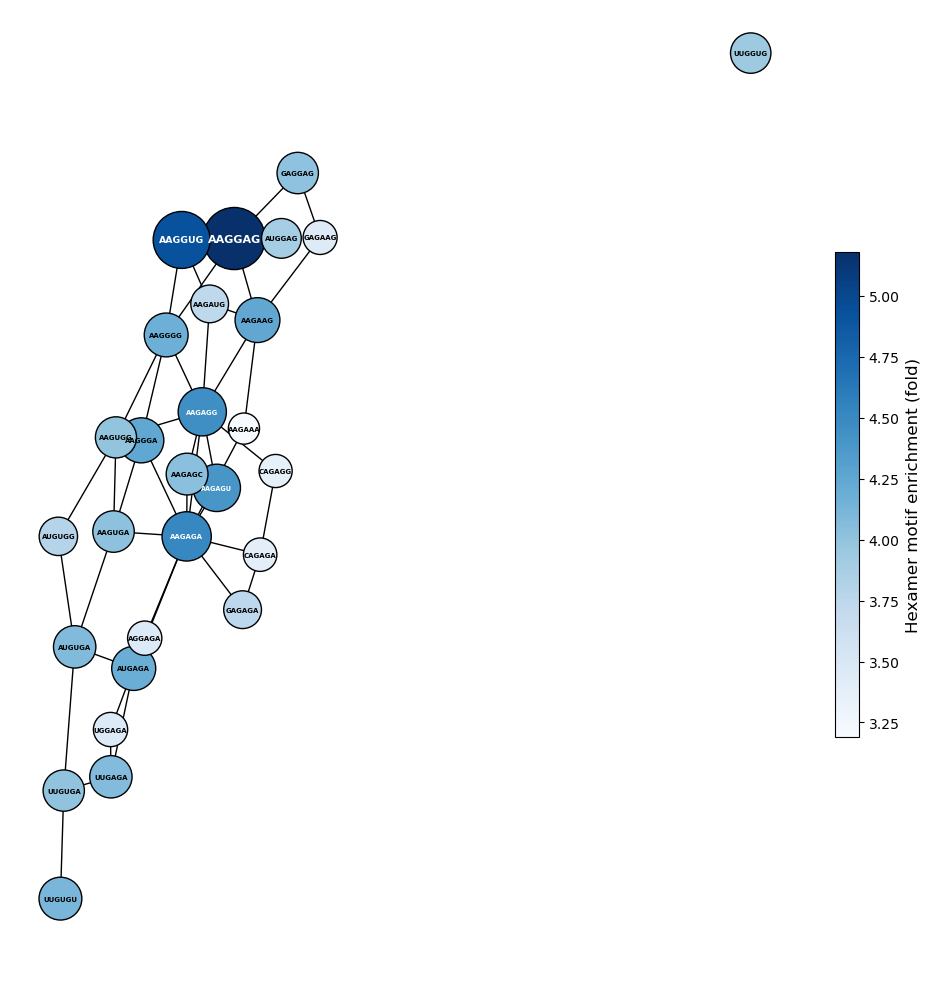

In [284]:
# Overall structure from ChatGPT, but I fixed the conditions, colormap, text size and position for better visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the graph
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', cmap=cmap)
nx.draw_networkx_edges(G, pos, edge_color='black')

# Customize node labels
labels = {node: node for node in G.nodes}
for node, (x, y) in pos.items():
    if G.nodes[node]['Motif Enrichment (fold)'] < 20:
        font_size = 5
        nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size, font_weight='bold')

    else:
        font_size = 8*G.nodes[node]['Motif Enrichment (fold)']/(max(motif_enrichment))
        # If the text fits inside the node, print it in white color
        nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size,
                                font_color='white', font_weight='bold')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, )  # Provide the ax argument
cbar.set_label('Hexamer motif enrichment (fold)', fontsize=12)

# Remove the axis
ax.axis('off')

# Show the plot
plt.tight_layout()
plt.savefig('Seojin_Termproj/Hexamer_motif_network.png')
plt.show()